In [1]:
import cv2     # for capturing videos
import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
import numpy as np    # for mathematical operations
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images


Using TensorFlow backend.


In [2]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np

from PIL import Image

from skimage.feature import hog
from skimage.color import rgb2grey

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import roc_curve, auc

In [3]:
data = pd.read_csv('./mapping.csv')

In [4]:
data

,Image_ID,Y
0,Complete_house_1.png,0
1,Complete_house_2.png,0
2,Wrecked_house_1.png,1
3,Wrecked_house_2.png,1
4,Complete_house_3.png,0
5,Wrecked_house_3.jpg,1
6,Complete_house_4.png,0
7,Wrecked_house_4.jpg,1
8,Complete_house_5.png,0


In [10]:
height = 200
width = 300
depth = 4

In [6]:
X = []
for img_name in data.Image_ID:
    img = plt.imread('' + img_name)
    a = resize(img, preserve_range=True, output_shape=(height,width,depth))
    X.append(a)
X = np.array(X)

In [7]:
grey_houses = rgb2grey(X)

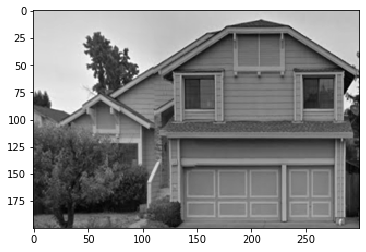

In [8]:
plt.imshow(grey_houses[0], cmap=mpl.cm.gray)

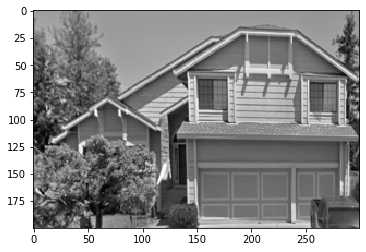

In [9]:
plt.imshow(grey_houses[1], cmap=mpl.cm.gray)

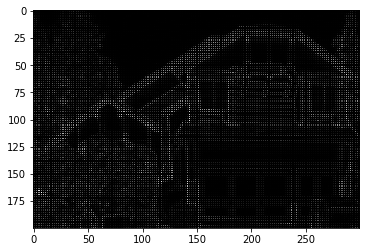

In [10]:
# run HOG using our greyscale bombus image
hog_features, hog_image = hog(grey_houses[1],
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(2, 2))

plt.imshow(hog_image, cmap=mpl.cm.gray)

In [11]:
def create_features(images):
    # flatten three channel color image
    multi_flat_features = []
    for img in images:
        color_features = img.flatten()
        # convert image to greyscale
        grey_image = rgb2grey(img)
        # get HOG features from greyscale image
        hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(2, 2))
        # combine color and hog features into a single array
        flat_features = np.hstack(color_features)
        multi_flat_features.append(flat_features)
    return np.array(multi_flat_features)

In [12]:
feature_matrix = create_features(X)

In [13]:
# get shape of feature matrix
print('Feature matrix shape is: ', feature_matrix.shape)

Feature matrix shape is:  (9, 240000)


In [22]:
# define standard scaler
ss = StandardScaler()
# run this on our feature matrix
bees_stand = ss.fit_transform(feature_matrix)

pca = PCA(n_components=9)
# use fit_transform to run PCA on our standardized matrix
bees_pca = pca.fit_transform(bees_stand)
# look at new shape
print('PCA matrix shape is: ', bees_pca.shape)

PCA matrix shape is:  (9, 9)


In [23]:
X = pd.DataFrame(bees_pca)
y = pd.Series(data.Y)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.3,
                                                    random_state=1234123)

# look at the distrubution of labels in the train set
pd.Series(y_train).value_counts()

1    3
0    3
Name: Y, dtype: int64

In [24]:
pd.Series(y_test).value_counts()

0    2
1    1
Name: Y, dtype: int64

In [25]:
# define support vector classifier
svm = SVC(kernel='rbf', probability=True, random_state=42, gamma="scale")

# fit model
svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [26]:
# generate predictions
y_pred = svm.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.6666666666666666


In [27]:
accuracy_score(y_train, svm.predict(X_train))

0.8333333333333334

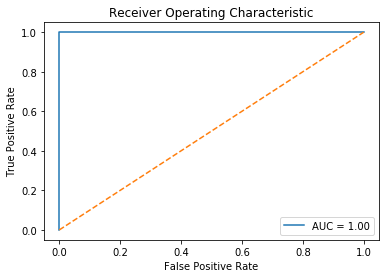

In [182]:
# predict probabilities for X_test using predict_proba
probabilities = svm.predict_proba(X_test)

# select the probabilities for label 1.0
y_proba = probabilities[:, 1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)

# calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
# plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

In [185]:
probabilities

array([[0.3061705 , 0.6938295 ],
       [0.30619191, 0.69380809],
       [0.30617418, 0.69382582]])

In [63]:
from google.cloud import vision
from google.cloud.vision import types
from google.oauth2 import service_account
import os
import io
import json
from google.protobuf.json_format import MessageToDict
import time 

In [64]:
GOOGLE_SERVICE_KEY = '/Users/gourik/Desktop/ToLearn/DSI/DSI-10/projects/capstone/InformDamage-436667444ca9.json'
credentials = service_account.Credentials.from_service_account_file(GOOGLE_SERVICE_KEY)
client = vision.ImageAnnotatorClient(credentials=credentials)

def get_damage_type(file_name):
    '''
        Instantiates a client
        Input: image file by file_name: str
        Output: damage type: str
    '''

    # Loads the image into memory
    with io.open(file_name, 'rb') as image_file:
        content = image_file.read()
    image = types.Image(content=content)
    response = client.label_detection(image=image, max_results=100)
    time.sleep(5)
    res = MessageToDict(response)

    return res


In [65]:
label_d_lst = []

In [66]:

def get_labels(e, res, label_d_lst, col_no):    
    new_lst = []
    for i in range(len(res["labelAnnotations"])):
        new_lst.append(res["labelAnnotations"][i]["description"])
#         try:
# #             label_d_lst[res["labelAnnotations"][i]["description"]].append(round(res["labelAnnotations"][i]["score"],2))
#         except:
#             pass
        
#     for v in label_d_lst:
#         if len(label_d_lst[v]) == 0 and col_no == 0:
#             label_d_lst[v].append(0)
#         elif len(label_d_lst[v]) - 1 < col_no:
#             label_d_lst[v].append(0)
    
    label_d_lst.append((e, new_lst))    

In [67]:
entries = os.listdir('./Rubbled houses/')

In [68]:
for i, e in enumerate(entries):
    print("\nReading  : {}".format(e))
    res = get_damage_type('./Rubbled houses/' + e)
    print("Got from vision  : {}".format(e))
    get_labels(e, res, label_d_lst, i)
    print("Done : {}".format(e))


Reading  : 08_100.jpg
Got from vision  : 08_100.jpg
Done : 08_100.jpg

Reading  : 21_25.jpeg
Got from vision  : 21_25.jpeg
Done : 21_25.jpeg

Reading  : 01_100.jpg
Got from vision  : 01_100.jpg
Done : 01_100.jpg

Reading  : 07_25.jpg
Got from vision  : 07_25.jpg
Done : 07_25.jpg

Reading  : 13_50.jpg
Got from vision  : 13_50.jpg
Done : 13_50.jpg

Reading  : 11_100.jpg
Got from vision  : 11_100.jpg
Done : 11_100.jpg

Reading  : 15_25.jpg
Got from vision  : 15_25.jpg
Done : 15_25.jpg

Reading  : 01_50.jpg
Got from vision  : 01_50.jpg
Done : 01_50.jpg

Reading  : 2_100.jpg
Got from vision  : 2_100.jpg
Done : 2_100.jpg

Reading  : 23_25.jpg
Got from vision  : 23_25.jpg
Done : 23_25.jpg

Reading  : 16_75.jpg
Got from vision  : 16_75.jpg
Done : 16_75.jpg

Reading  : 14_0.jpg
Got from vision  : 14_0.jpg
Done : 14_0.jpg

Reading  : flood_1.jpeg
Got from vision  : flood_1.jpeg
Done : flood_1.jpeg

Reading  : 04_75.jpg
Got from vision  : 04_75.jpg
Done : 04_75.jpg

Reading  : 09_25.jpg
Got from

Got from vision  : 19_75.jpeg
Done : 19_75.jpeg


In [73]:
pd.DataFrame(label_d_lst).to_csv("words_from_google_vision.csv")

In [18]:
df = pd.DataFrame(label_d_lst)

In [19]:
df_im = pd.DataFrame(entries, columns=["Images"])


In [21]:
df = pd.concat((df_im, df), axis=1)

In [22]:
df

,Images,Demolition,Earthquake,Event,Flood,Floodplain,Geological phenomenon,Home,House,Land lot,Lighting,Manor house,Property,Real estate,Rubble,Ruins,Scrap,Tsunami,Waste
0,08_100.jpg,0.00,0.0,0.0,0.0,0.0,0.00,0.76,0.87,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00
1,21_25.jpeg,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.59,0.00,0.0,0.0,0.88,0.70,0.0,0.0,0.00,0.0,0.00
2,01_100.jpg,0.55,0.0,0.0,0.0,0.0,0.00,0.78,0.59,0.71,0.0,0.0,0.88,0.00,0.0,0.0,0.75,0.0,0.72
3,07_25.jpg,0.00,0.0,0.0,0.0,0.0,0.00,0.90,0.94,0.00,0.0,0.0,0.93,0.65,0.0,0.0,0.00,0.0,0.00
4,13_50.jpg,0.00,0.0,0.0,0.0,0.0,0.00,0.00,0.78,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,01_0.jpg,0.00,0.0,0.0,0.0,0.0,0.00,0.99,0.99,0.00,0.0,0.0,0.98,0.95,0.0,0.0,0.00,0.0,0.00
114,13_75.jpg,0.00,0.0,0.0,0.0,0.0,0.00,0.99,0.98,0.00,0.0,0.0,0.96,0.88,0.0,0.0,0.00,0.0,0.00
115,03_0.jpg,0.00,0.0,0.0,0.0,0.0,0.00,0.99,0.98,0.00,0.0,0.0,0.98,0.94,0.0,0.0,0.00,0.0,0.00
116,13_25(1).jpg,0.00,0.0,0.0,0.0,0.0,0.00,0.97,0.97,0.00,0.0,0.0,0.95,0.88,0.0,0.0,0.00,0.0,0.00


In [31]:
img = plt.imread('./Rubbled houses/' + df["Images"][0])

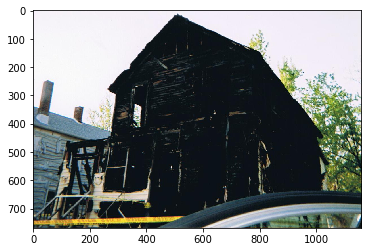

In [32]:
plt.imshow(img)